# Efficient language detection model using Naive Bayes

Author:
 - Samuele Marino

Language detection goal is to create a model that is able to detect the language a text is written in.
Data Scientists usually employ neural network models to accomplish such a goal. In this notebook indeed, I create a language detection model using a Naive Bayes model.

## The problem

The problem we are going to face is to create a model that, once fed with a text, is able to detect its language. The text can be a sentence, a word, a more complicated text, and so on. The output variable can be, for example, the language code.

A good idea would be to have a model that detects the language of a text even if this text contains words that the model has not seen in the training phase. We want a model that can generalize the underlying structure of a language in a way that makes it detect it properly.

## The model

The model I’m going to use in order to solve the prblem is a Multinomial Naive Bayes. It’s a very simple model and Naive Bayes is, generally speaking, very powerful in Natural Language Processing. It almost has no hyperparameters, so we can focus on the pre-processing phase, which is the most critical.

I will implement unigram and bigram model.
Although there is already existing implementation in scikit-learn package, for unigram I want to recreate the algorithm from scratch. While for bigramm I use scikit-learn implementation.

## Unigram

In order to label the language we need to compute the probability than an text is English or Italian or French or ... given that the words W are in the text, $P(L = English|W)$ and $P(L = Italian|W)$ and so on and so forth.

The probability that text is english given that the text contains the words W is
\begin{equation*}
P(L = English|W) = \frac{P(W|L = English)P(L = English)}{P(W)}
\end{equation*}
where:
\begin{equation*}
P(W|L = English)=P(w_1,w_2,...,w_n|L = English)=\prod_{i=1}^{n}P(w_i|L = English)
\end{equation*}
and
\begin{equation*}
P(W)=P(W|L = English)P(L = English)+P(W|L = Italian)P(L = Italian) + ...
\end{equation*}
or
\begin{equation*}
P(W)= \sum_{l \in L}P(W|L = l)P(L = l)
\end{equation*}

$P(L|W)$ can be calculated similarly for all languages labels, so we can say that:
\begin{equation*}
P(L|W) \propto \prod_{i=1}^{n}P(w_i|L)P(L)
\end{equation*}

There is the possibility that same probability is really small, so it's a good idea change the space to $log$ space to prevent underflow.

\begin{align*}
\ln(P(L = &English|W)) \propto \\
\ln(\prod_{i=1}^{n}P(w_i|L = En&glish)P(L = English)) \\
= \ln(P(L = English)&\prod_{i=1}^{n}P(w_i|L = English)) = \\
\ln(P(L = English)) + &\sum_{i=1}^{n}\ln(P(w_i|L = English))
\end{align*}
The same operation can be applied to $P(L|W)$ 

or
\begin{align*}
\ln(P(L|W)) \propto \ln(\prod_{i=1}^{n}P(w_i|L )P(L)) = \ln(P(L)\prod_{i=1}^{n}P(w_i|L)) &= \ln(P(L)) + \sum_{i=1}^{n}\ln(P(w_i|L))
\end{align*}


We can assume that the words are generated following a multinomial distribution and are independent.
So we can compute $P(W|L)$.
\begin{equation*}
P(W|L) = \frac{N_{W,L} + \alpha}{N_L + \alpha N_V}
\end{equation*}

where:
- $N_V$ is the number of unique words in the whole dataset.
- $N_L$ is the total number of words in the specific language text.
- $N_{W,L}$ is the number of occurrences of the word $W$ in all specific language text.
- $\alpha$ is smoothing parameter. It prevents this value from being 0 if there are few occurrences of a particular word. In doing so it prevents our calculation from being highly inaccurate. It also prevents a divide-by-zero error.

Let's write some code...

### Import libraries

In [1]:
from math import log
import pandas as pd
from sklearn.model_selection import train_test_split
from seaborn import heatmap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from copy import copy

### Dataset

I will use the Language Detection Dataset by Basil Saji. It is free and can be downloaded from [Kaggle](https://www.kaggle.com/datasets/basilb2s/language-detection?resource=download).

Dataset structure is simple. It contains two columns:
- one for the text.
- one for the label.

In [2]:
url = "Dataset/Language Detection.csv"
data = pd.read_csv(url, sep=',')

data.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [3]:
data.groupby('Language').count()

,Text
Language,
Arabic,536
Danish,428
Dutch,546
English,1385
French,1014
German,470
Greek,365
Hindi,63
Italian,698


In [4]:
languages = data['Language'].unique()

### Preparation

Before the algorithm application, I prepare data. First of all, I will remove the punctuation. Then I will convert all the text into the lower-case and split it into the separate words.

In [ ]:
data_clean = data.copy()

data_clean['Text'] = data_clean['Text'].str.replace('\W+', ' ').str.replace('\s+', ' ').str.strip()
data_clean['Text'] = data_clean['Text'].str.lower()
data_clean['Text'] = data_clean['Text'].str.split()

In [105]:
data_clean['Text'].head()

0    [nature, in, the, broadest, sense, is, the, na...
1    [nature, can, refer, to, the, phenomena, of, t...
2    [the, study, of, nature, is, a, large, if, not...
3    [although, humans, are, part, of, nature, huma...
4    [1, the, word, nature, is, borrowed, from, the...
Name: Text, dtype: object

#### Split to train and test data

In [7]:
train_data, test_data = train_test_split(data_clean, test_size=0.33, random_state=42)

In [107]:
print(f'The number of sample in the train data is: {train_data.shape[0]}')
train_data['Language'].value_counts() / train_data.shape[0] * 100

The number of sample in the train data is: 6925


English       12.981949
French         9.732852
Spanish        7.942238
Portugeese     7.191336
Russian        6.859206
Italian        6.657040
Sweedish       6.657040
Malayalam      5.689531
Dutch          5.184116
Arabic         5.111913
German         4.664260
Turkish        4.592058
Tamil          4.534296
Danish         4.173285
Kannada        3.754513
Greek          3.653430
Hindi          0.620939
Name: Language, dtype: float64

In [108]:
print(f'The number of sample in the test data is: {test_data.shape[0]}')
test_data['Language'].value_counts() / test_data.shape[0] * 100

The number of sample in the test data is: 3412


English       14.243845
French         9.964830
Spanish        7.883939
Portugeese     7.063306
Italian        6.946073
Russian        6.359906
Sweedish       6.301290
Malayalam      5.861665
Dutch          5.480657
Arabic         5.334115
Turkish        4.572098
Tamil          4.542790
German         4.308324
Danish         4.073857
Greek          3.282532
Kannada        3.194607
Hindi          0.586166
Name: Language, dtype: float64

In [109]:
test_data.head()

,Text,Language
6662,"[и, с, этими, словами, она, села, в, его, каре...",Russian
7362,"[sistemi, di, tipo, probabilistico, erano, inv...",Italian
765,"[machine, learning, involves, computers, disco...",English
6192,"[несколько, языковых, версий, опубликовали, по...",Russian
562,"[225, in, may, 2014, wikimedia, foundation, na...",English


### Prepare vocabulary

I prepare the vocabulary and count the number of separate words in each text.

In [12]:
vocabulary = list(dict.fromkeys(train_data['Text'].sum()))
print(f'The length of the vocabulary is: {len(vocabulary)}')

The length of the vocabulary is: 31744


Calculate frequencies of the words for each message

In [13]:
word_counts_per_text = pd.DataFrame([
    [row[0].count(word) for word in vocabulary]
    for _, row in train_data.iterrows()], columns=vocabulary)

save vocabulary (Optional)

In [ ]:
# word_counts_per_text.to_csv('vocabulary.csv')

load vocabulary (Optional)

In [8]:
# url = './vocabulary.csv'
# word_counts_per_text = pd.read_csv(url, sep=',')
# word_counts_per_text = word_counts_per_text.drop('Unnamed: 0', axis=1)

In [9]:
train_data_voc = pd.concat([train_data.reset_index(), word_counts_per_text], axis=1).iloc[:,1:]

In [17]:
train_data_voc.head()

,Text,Language,agora,mesmo,examples,include,artificial,neural,networks,multilayer,...,πλήρως,conexiones,pesos,numéricos,generality,simulation,multi,swarm,dedicate,mobili
0,"[agora, mesmo]",Portugeese,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[examples, include, artificial, neural, networ...",English,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,"[140, the, list, concerns, basic, content, by,...",English,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[därmed, är, det, möjligt, att, länka, till, j...",Sweedish,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[ainsi, celle, ci, se, vengera, de, ce, qu, on...",French,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculate values for the Bayes formula

In [13]:
alpha = 1
Nvoc = len(vocabulary)
P_languages = dict(zip(languages,
                       [train_data['Language'].value_counts()[language] / train_data.shape[0] for language in languages]))
N_languages = dict(zip(languages,
                       [train_data.loc[train_data['Language'] == language, 'Text'].apply(len).sum() for language in languages]))


To complete the formula we will define the functions to determine the probabilities of the given word to belong to a language:

In [14]:
def p_w_l(word, language):
    if word in train_data_voc.columns:
        Nwl = train_data_voc.loc[train_data_voc['Language'] == language, word].sum()
        return (Nwl + alpha) / (N_languages[language] + alpha*Nvoc)
    else:
        return 1


In [ ]:
def p_w_l(word, language):
    Nwl = train_data_voc.loc[train_data_voc['Language'] == language, word].sum(
    ) if word in train_data_voc.columns else 0
    return (Nwl + alpha) / (N_languages[language] + alpha*Nvoc)


### Prepare the classificator

In [15]:
def log_classify(message):
    p_language_gien_text = copy(P_languages)
    p_language_gien_text = {k: log(v) for (k, v) in p_language_gien_text.items()}
    for language in languages: 
        for word in message:
            p_language_gien_text[language] += log(p_w_l(word, language))
    return max(p_language_gien_text, key=p_language_gien_text.get)


### Testing on the data test

In [ ]:
test_data['predicted'] = test_data['Text'].apply(log_classify)

In [17]:
test_data

,Text,Language,predicted
6662,"[и, с, этими, словами, она, села, в, его, каре...",Russian,Russian
7362,"[sistemi, di, tipo, probabilistico, erano, inv...",Italian,Italian
765,"[machine, learning, involves, computers, disco...",English,English
6192,"[несколько, языковых, версий, опубликовали, по...",Russian,Russian
562,"[225, in, may, 2014, wikimedia, foundation, na...",English,English
...,...,...,...
2631,"[algumas, edições, da, wikipédia, como, a, wik...",Portugeese,Portugeese
8570,"[i, denna, dump, har, man, försökt, hitta, red...",Sweedish,Sweedish
9082,"[ي, عرف, هذا, باسم, وجهة, نظر, محايدة, npov]",Arabic,Arabic
401,"[114, this, method, of, evaluating, contributi...",English,English


In [18]:
ac = accuracy_score(test_data['Language'], test_data['predicted'])
print(f'The correct prediction are {ac*100:.2f}%')

The correct prediction are 98.07%


Uncorrect Prediction

In [20]:
test_data.loc[test_data['predicted'] != test_data['Language']]

,Text,Language,predicted
8043,"[ben, yine, de, çamaşır, yıkayacağım]",Turkish,Dutch
4148,"[allez, y]",French,Spanish
5461,[perdóneme],Spanish,English
8093,[ilgilenmiyorum],Turkish,English
7754,[scusandosi],Italian,English
...,...,...,...
1332,"[no, worries]",English,Spanish
8758,"[rockar, du, rock]",Sweedish,Danish
3018,"[desculpe, incomodá, lo]",Portugeese,Spanish
5456,[vacilando],Spanish,English


### Confusion Matrix

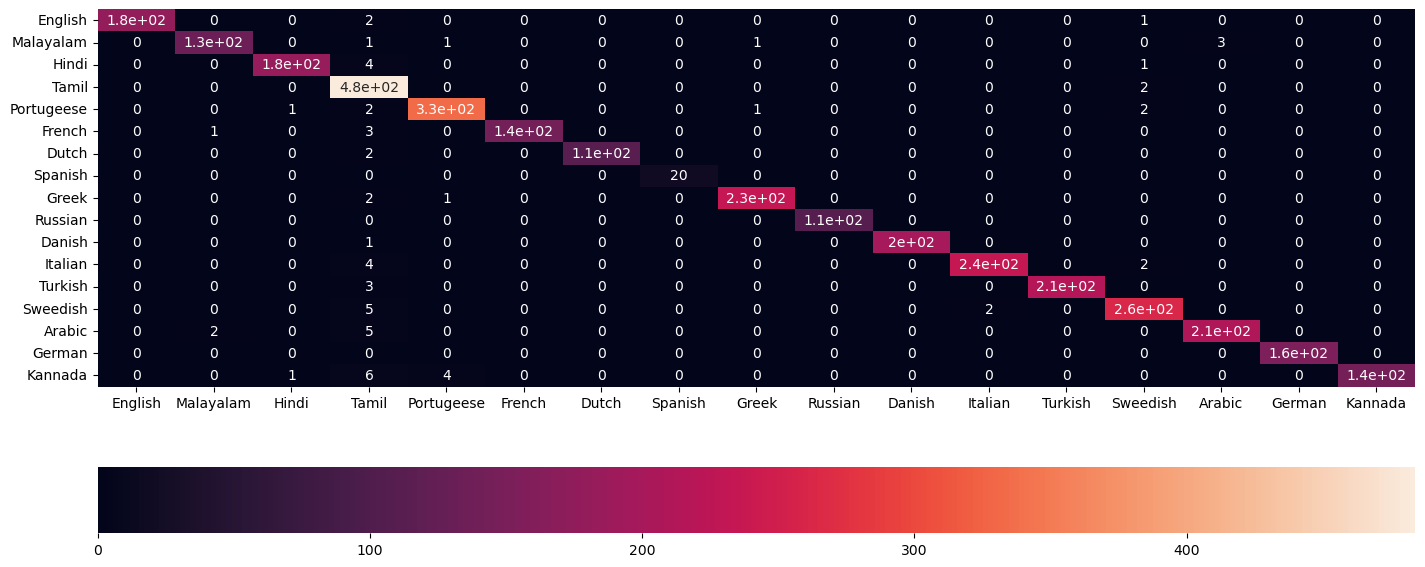

In [51]:
cm = confusion_matrix(test_data['Language'], test_data['predicted'])
plt.figure(figsize=(17, 7))
heatmap(cm,
        annot=True,
        xticklabels=languages,
        yticklabels=languages,
        cbar_kws={'orientation': 'horizontal'},)
plt.show()

### Classification report

In [22]:
print(classification_report(test_data['Language'], test_data['predicted']))

              precision    recall  f1-score   support

      Arabic       1.00      0.98      0.99       182
      Danish       0.98      0.96      0.97       139
       Dutch       0.99      0.97      0.98       187
     English       0.92      1.00      0.96       486
      French       0.98      0.98      0.98       340
      German       1.00      0.97      0.99       147
       Greek       1.00      0.98      0.99       112
       Hindi       1.00      1.00      1.00        20
     Italian       0.99      0.99      0.99       237
     Kannada       1.00      1.00      1.00       109
   Malayalam       1.00      0.99      1.00       200
  Portugeese       0.99      0.98      0.98       241
     Russian       1.00      0.99      0.99       217
     Spanish       0.97      0.97      0.97       269
    Sweedish       0.99      0.97      0.98       215
       Tamil       1.00      1.00      1.00       155
     Turkish       1.00      0.93      0.96       156

    accuracy              

## Bigram

### Import libraries

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

### Clean data

In [ ]:
data_clean_bigram = data.copy()

data_clean_bigram['Text'] = data_clean_bigram['Text'].str.replace('\W+', ' ').str.replace('\s+', ' ')
data_clean_bigram['Text'] = data_clean_bigram['Text'].str.lower()

### Split data

In [32]:
X = data_clean_bigram['Text']
y = data_clean_bigram['Language']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Converting text

we are converting text into numerical form by creating a Bag of Words model using CountVectorizer

In [39]:
cnt = CountVectorizer(analyzer='char', ngram_range=(2, 2))

### Pipeline

we create the pipeline that vectorizes our data and gives it to the model, which is a Multinomial Naive Bayes.

In [54]:
pipeline = Pipeline([
    ('vectorizer', cnt),
    ('model', MultinomialNB())
])

pipeline.fit(X_train, y_train);

### Testing on the data test

In [53]:
y_pred = pipeline.predict(X_test)

In [41]:
ac = accuracy_score(y_test, y_pred)
print(f'The correct prediction are {ac*100:.2f}%')

The correct prediction are 97.57%


### Confusion Matrix

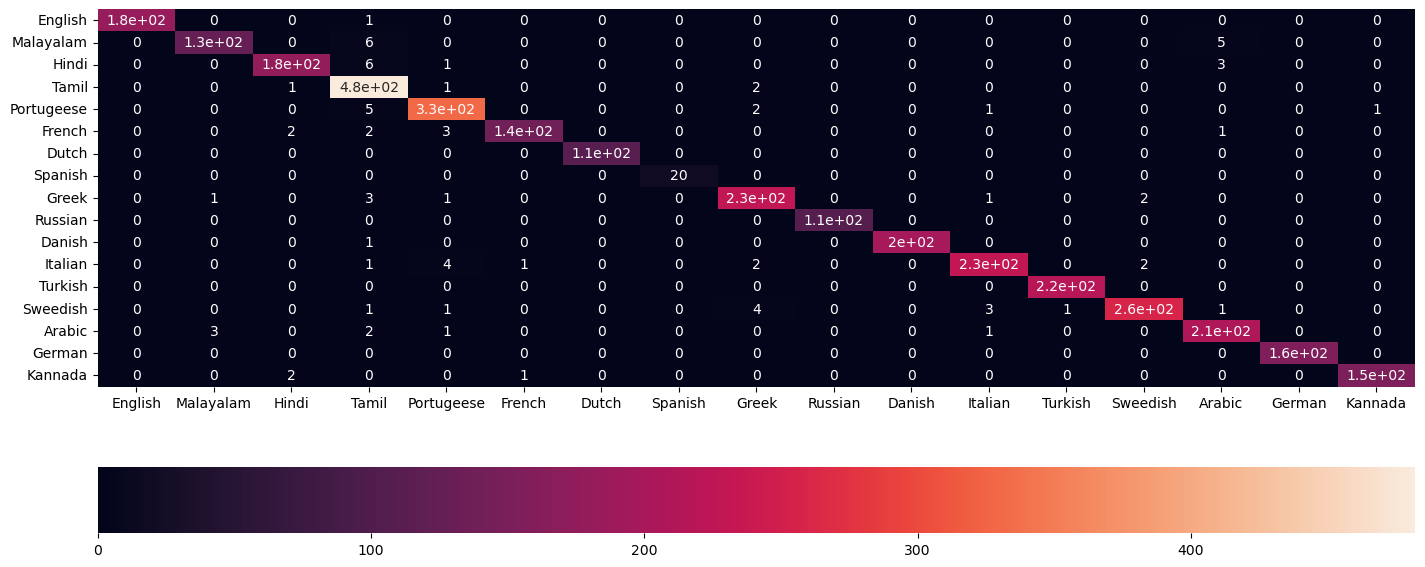

In [47]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(17, 7))
heatmap(cm, 
        annot=True, 
        xticklabels=languages, 
        yticklabels=languages,
        cbar_kws={'orientation': 'horizontal'})
plt.show()

### Classification report

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Arabic       1.00      0.99      1.00       182
      Danish       0.97      0.92      0.94       139
       Dutch       0.97      0.95      0.96       187
     English       0.95      0.99      0.97       486
      French       0.97      0.97      0.97       340
      German       0.99      0.95      0.97       147
       Greek       1.00      1.00      1.00       112
       Hindi       1.00      1.00      1.00        20
     Italian       0.96      0.97      0.96       237
     Kannada       1.00      1.00      1.00       109
   Malayalam       1.00      0.99      1.00       200
  Portugeese       0.97      0.96      0.97       241
     Russian       1.00      1.00      1.00       217
     Spanish       0.98      0.96      0.97       269
    Sweedish       0.95      0.97      0.96       215
       Tamil       1.00      1.00      1.00       155
     Turkish       0.99      0.98      0.99       156

    accuracy              